In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory, simulate_1d

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

In [2]:
pool = Pool(8)

In [3]:
def get_RSH(o0,g0,b,ka):

    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    return R,S,H, 2*(R*S+H**2)

In [4]:
# params - o0,g0,b,th,ka

params = [
#     (1.69,0.18,3, 3.87),
#           (1.69,0.18,1.5, 3.87),
          (1.69,0.18,7, 3.87),
          
#           (0.96,0.18,1,0.2),
          (0.96,0.18,2,0.2),
#           (0.96,0.18,0.5,0.2),
]

R,S,H, varL = list(zip(*[get_RSH(*a) for a in params]))

In [5]:
np.array(list(zip(R,S,H)))

array([[   1.15804802,   12.52476963,   -1.29829567],
       [  72.45852623,  347.05555556, -138.88888889]])

In [6]:
np.sqrt(varL)

array([  5.69031745, 298.11829039])

In [9]:
N=5000000
warmup=0
dt=0.001
samples=200
skip=1000
runs=16
time = np.linspace(0,N//skip *dt, N//skip)

In [10]:
results = []
for o0,g0,b,ka in tqdm(params):
    kwargs = dict(x0=np.zeros(samples),y0=np.zeros(samples),
                  vx0=np.zeros(samples),vy0=np.zeros(samples),
        N=N, samples=samples,
        dt=dt, warmup=warmup, skip=skip,
        omega0=o0,gamma0=g0,b=b, kappa=ka)
    results.append(simulate_2d_only_memory(pool,runs,**kwargs))

results = np.array(results)

In [12]:
results[:,:,:,:].shape

(2, 6, 3200, 5000)

In [13]:
cov = np.einsum("iakj,ibkj->ijab", results[:,:4,:,:],results[:,:4,:,:],optimize=True)/(results.shape[2]-1)

In [14]:
cov.shape

(2, 5000, 4, 4)

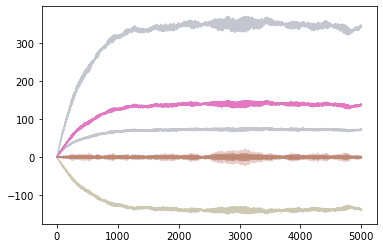

In [15]:
plt.plot(cov[1].reshape(-1,16), alpha=0.2);
plt.plot(cov[1,:,1,2]);

In [16]:
R_sample = results.var(axis=2)[:,0] 
S_sample = results.var(axis=2)[:,2]

In [36]:
L = (results[:,0] * results[:,3] - results[:,1] * results[:,2])
H_sample = L.mean(axis=1)/2

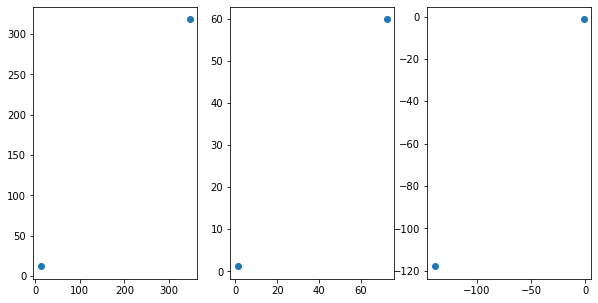

In [22]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.scatter(S, S_sample[..., -1])
plt.subplot(132)
plt.scatter(R, R_sample[..., -1])
plt.subplot(133)
plt.scatter(H, H_sample[..., -1])

In [18]:
results.shape

(2, 6, 3200, 5000)

In [19]:
L.shape

(2, 3200, 5000)

In [20]:
# T = results[:,2,:,:]
T = L/2
hlines = H

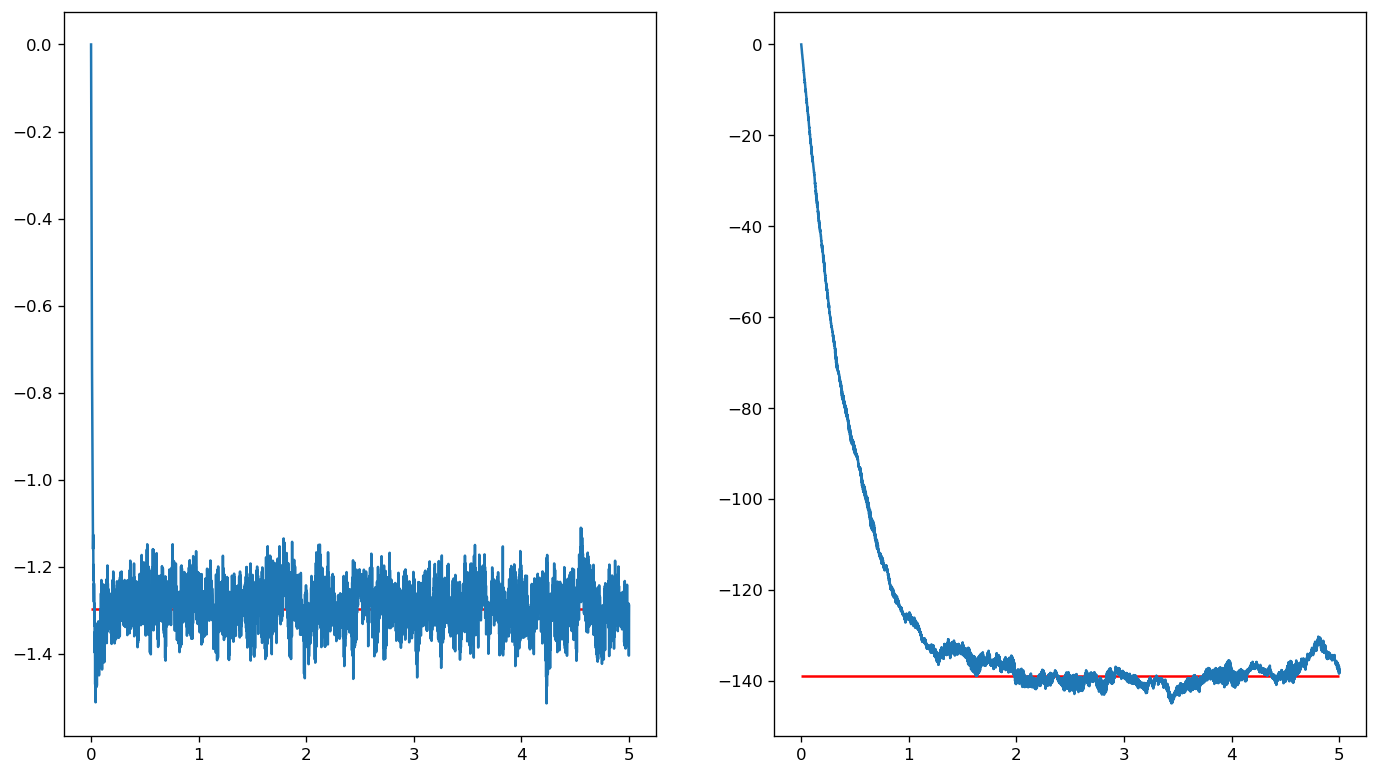

In [21]:
fig, axs = plt.subplots(T.shape[0]//2,2,figsize=(14,8),dpi=120)
for ax, xi,h in zip(axs.flatten(),T[:,:,:], hlines):
    ax.plot(time, xi.mean(axis=0))
    ax.hlines(y=h, xmin=0, xmax=max(time), colors="r")

In [23]:
L.shape

(2, 3200, 5000)

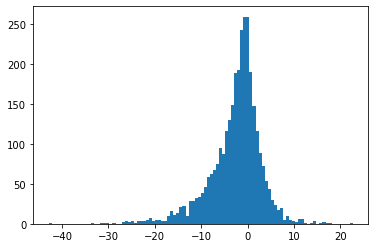

In [48]:
plt.hist(L[0,:,-1], bins=100);

In [32]:
L[1,:,-1].mean()

-276.2486766100835

In [40]:
sorted(L[1,:,-1])[1600]

-180.9030022232922

In [41]:
L.shape

(2, 3200, 5000)

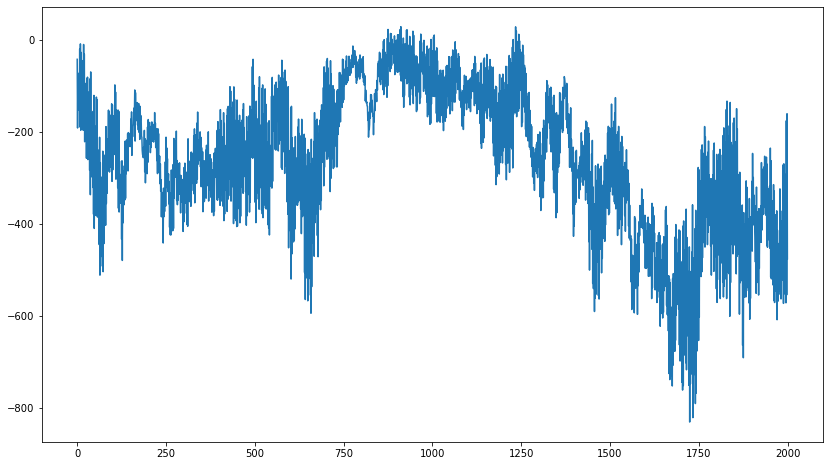

In [47]:
plt.figure(figsize=(14,8))
plt.plot(L[1,2,3000:])